In [3]:
import os
import pandas as pd
import sys
import json
from google.protobuf.json_format import Parse

sys.path.insert(0, 'compiled_protobufs')
from taskmap_pb2 import TaskMap

qrels_folder = os.path.join(os.getcwd(), 'measurements', 'judgments')
run_cooking_folder = os.path.join(os.getcwd(), 'measurements', 'cooking', 'run_files')
run_diy_folder = os.path.join(os.getcwd(), 'measurements', 'diy', 'run_files')
cooking_runs = os.listdir(run_cooking_folder)
cooking_qrles = os.path.join(qrels_folder, "cooking.qrels")

queries = {
    "COOKING" : pd.read_csv('queries/cooking.csv'),
    "DIY": pd.read_csv('queries/diy.csv'),
}


In [4]:
import ir_measures
from ir_measures import *
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np


def get_filepaths(folder):
  file_names = os.listdir(folder)
  return [os.path.join(folder, filename) for filename in file_names]

def get_accuracy(run_filepath, qrles_filepath):
    run = ir_measures.read_trec_run(run_filepath)
    qrles = ir_measures.read_trec_qrels(qrles_filepath)
    accuracy = ir_measures.calc_aggregate([nDCG@3, nDCG@5, nDCG@10, Precision@3, Precision@5, Precision@10, Recall@10, Recall@20, Recall@50, Judged@10, Judged@20, MAP], qrles, run)
    return accuracy

def get_precision_recall(run_filepath, qrles_filepath):
    run = ir_measures.read_trec_run(run_filepath)
    qrles = ir_measures.read_trec_qrels(qrles_filepath)
    precs = [IPrec@round(p,1) for p in np.arange(0,1.1,0.1)]
    iprec = ir_measures.calc_aggregate(precs, qrles, run)
    return iprec

def show_iprecs(results_iprec):
  precison_scores = np.arange(0, 1.1, 0.1)
  fig, ax = plt.subplots(figsize=(7,6))

  for model_name, res in results_iprec.items():
    recall_scores = res
    ax.plot(precison_scores,recall_scores, drawstyle='steps-pre',label=model_name)
  

  ax.set_xticks(np.arange(0, 1.1, step=0.1))
  ax.set_yticks(np.arange(0, 1.1, step=0.1))
  ax.set_xlim(left=0)
  ax.set_title(f"Precision-Recall Curve")
  ax.set_xlabel('Recall')
  ax.set_ylabel('Precision')
  ax.grid(axis='both', linestyle='--')
  ax.legend(loc='upper right')


# def get_stats(run_filepath, qrles_filepath):
    # run = ir_measures.read_trec_run(run_filepath)
    # qrles = ir_measures.read_trec_qrels(qrles_filepath)
    # precs = [IPrec(rel=2)@round(p,1) for p in np.arange(0,1.1,0.1)]
    # iprec = ir_measures.calc_aggregate(precs, qrles, run)
    # return iprec

In [24]:
for searcher in cooking_runs:
    run = os.path.join(run_cooking_folder, searcher)
    searcher_name = searcher[:-4].lower()
    accuracy = get_accuracy(run, cooking_qrles)
    print(searcher_name, accuracy)
    

bm25+rm3 {P@10: 0.5250000000000001, nDCG@10: 0.44329738192839563, R@20: 0.33482748503399457, AP: 0.26414729717991076, R@10: 0.2622747604108365, Judged@20: 0.6458333333333334, nDCG@3: 0.42877152069010754, P@3: 0.5416666666666667, P@5: 0.5166666666666667, R@50: 0.4680321947890273, Judged@10: 1.0, nDCG@5: 0.41115512795801795}
marqo-target {P@10: 0.425, nDCG@10: 0.3404694735639611, R@20: 0.24536674571370842, AP: 0.18244202730950032, R@10: 0.21730908212972902, Judged@20: 0.5312500000000001, nDCG@3: 0.3667353052237145, P@3: 0.4861111111111111, P@5: 0.4166666666666667, R@50: 0.27534345545048006, Judged@10: 0.9916666666666667, nDCG@5: 0.33174737416883704}
tct-colbertv2+t5-contents {P@10: 0.4958333333333332, nDCG@10: 0.5581451527391029, R@20: 0.3835455550305556, AP: 0.31506558945086055, R@10: 0.2645179276234442, Judged@20: 0.5000000000000001, nDCG@3: 0.7112240407078415, P@3: 0.708333333333333, P@5: 0.6166666666666668, R@50: 0.4833159008134988, Judged@10: 0.6208333333333332, nDCG@5: 0.6405771869

In [6]:


diy_runs = os.listdir(run_diy_folder)
diy_qrles = os.path.join(qrels_folder, "diy.qrels")

results = {}
for searcher in sorted(diy_runs):
    run = os.path.join(run_diy_folder, searcher)
    searcher_name = searcher[:-4].lower()
    # print(searcher_name, run)
    accuracy = get_accuracy(run, diy_qrles)
    results[searcher_name] = accuracy
    # print(searcher_name, accuracy)
    # print(type(accuracy))
    
df = pd.DataFrame(results).transpose()
# df[["AP", "nDCG@3", "nDCG@5", "nDCG@10", "P@3", "P@5", "P@10", "R@10", "R@25"]]
df.to_csv("/home/ubuntu/task-search-quality/measurements/diy/analysis/all-metrics.csv")
df

,R@10,AP,P@5,Judged@20,nDCG@3,Judged@10,nDCG@10,P@3,P@10,R@50,R@20,nDCG@5
tct-colbertv2+t5,0.480994,0.568235,0.804,0.7855,0.740442,1.0,0.710087,0.836667,0.675,0.735527,0.649272,0.730889
tct-colbertv2,0.453904,0.529378,0.774,0.7390,0.746081,1.0,0.669332,0.833333,0.632,0.735527,0.594048,0.706039
ance+t5,0.457818,0.509876,0.796,0.7330,0.742306,1.0,0.685964,0.830000,0.646,0.645498,0.583292,0.725213
ance,0.393009,0.438728,0.700,0.6965,0.711243,1.0,0.617387,0.783333,0.558,0.645498,0.506185,0.658291
bm25+rm3+t5,0.498971,0.587040,0.780,0.7905,0.729661,1.0,0.706960,0.806667,0.699,0.767079,0.666616,0.709245
bm25+rm3,0.429967,0.519291,0.696,0.7585,0.623118,1.0,0.603841,0.736667,0.614,0.767079,0.609026,0.602188
bm25+t5,0.487030,0.571450,0.766,0.7995,0.717828,1.0,0.695795,0.786667,0.682,0.753001,0.662134,0.697716
bm25,0.410965,0.495706,0.690,0.7665,0.623117,1.0,0.584395,0.726667,0.583,0.753001,0.592493,0.603073
marqo+t5,0.481024,0.566851,0.788,0.7750,0.731562,1.0,0.699439,0.826667,0.669,0.735711,0.657876,0.712714
marqo,0.393111,0.455095,0.660,0.7250,0.610497,1.0,0.567989,0.710000,0.548,0.732027,0.530082,0.582673


TCT-ColBERTv2.run [0.9808095238095237, 0.9318441558441559, 0.854161707401645, 0.7622814796172273, 0.6631597347663025, 0.5913946152016727, 0.46237309203419685, 0.3310725364238594, 0.2252701646850586, 0.11553921014752659, 0.053862848718972796]
ance.run [0.9559294871794871, 0.8936487854251014, 0.7904732157938682, 0.6885406955604644, 0.586709978883333, 0.45462092979953395, 0.3089510809825998, 0.1834307183832389, 0.09702540002986783, 0.04791314508644834, 0.01603809523809524]
bm25+rm3.run [0.8929536720589353, 0.8534486215538847, 0.7957327934248258, 0.731199765049692, 0.6475221177208355, 0.5709107068957379, 0.4564928636608442, 0.3777409408278394, 0.2668709105862699, 0.17179922923095645, 0.12206144487292671]
bm25.run [0.9053224969474968, 0.8577539682539681, 0.7696566404569498, 0.6973474214124369, 0.6090427042287739, 0.5446242797071394, 0.4289961718101405, 0.3412156941072282, 0.23810550972853664, 0.14906452572051715, 0.09896694122780741]
marqo.run [0.9030952935952936, 0.8322634380243075, 0.7412

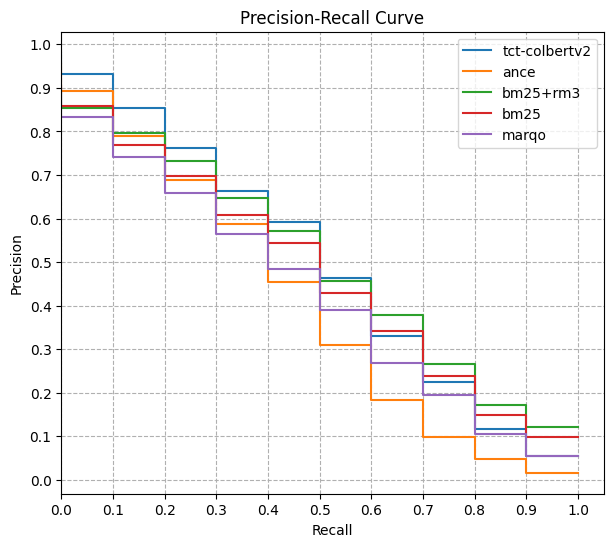

In [26]:
results_iprec = {}
precs = [IPrec@round(p,1) for p in np.arange(0,1.1,0.1)]
for searcher in sorted(diy_runs):
    if "t5" in searcher:
      continue  
    run = os.path.join(run_diy_folder, searcher)
    searcher_name = searcher[:-4].lower()
    iprec = get_precision_recall(run, diy_qrles)
    vals = [iprec[prec] for prec in precs]
    results_iprec[searcher_name] = vals
    print(searcher, vals)
show_iprecs(results_iprec)

In [55]:
diy_runs = os.listdir(run_diy_folder)
diy_qrles = os.path.join(qrels_folder, "diy.qrels")

judgments = []
with open(diy_qrles, "r") as f:
    for j in f:
        judgment = j.strip().split(" ")
        judgment[3] = int(judgment[3])
        judgments.append(judgment)

diy_pd = pd.DataFrame(judgments, columns = ['qid', 'run', 'docid', "score"])

diy_pd.head()
stats_pd = diy_pd.groupby(by=["qid"])["score"].agg(['count', 'mean', 'std']).reset_index()
stats_pd["id"] = stats_pd["qid"].str.replace("query-", "").astype(int)
stats_pd = stats_pd.sort_values(by=['id'])
stats_pd.head()


,qid,count,mean,std,id
0,query-0,91,0.505495,0.689180,0
1,query-1,55,0.763636,0.719147,1
12,query-2,44,0.545455,0.663134,2
23,query-3,34,0.558824,0.704581,3
34,query-4,70,0.500000,0.717282,4


10
4
4
9
9
18
18
14
14
5
5
16
16
8
8
9
9
16
16
12
12


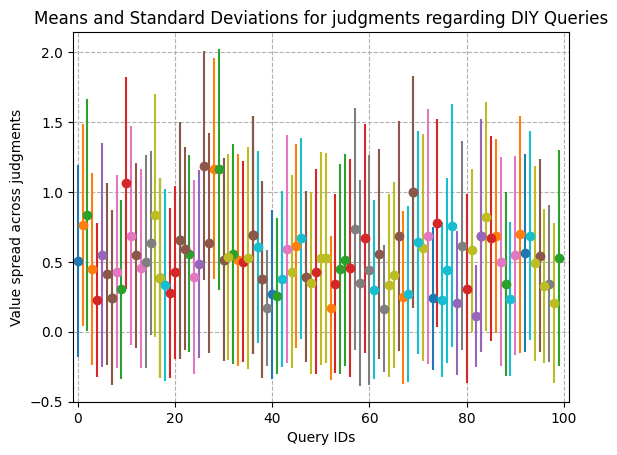

In [61]:
import matplotlib.pyplot as plt

colors = ['red', 'green', 'blue', 'black', 'pink', 'purple', 'orange', 'yellow', 'cyan', 'brown']

print(len( df["model"].unique()))
df = pd.read_csv("/home/ubuntu/task-search-quality/measurements/diy/analysis/diy-MAP-best.csv")
df.head()
for model_name, color in zip(df["model"].unique(), colors):
    points_to_plot = df[df["model"] == model_name]
    print(len(points_to_plot))
    filtered_df = stats_pd[stats_pd["qid"].isin(points_to_plot['query_id'])]
    print(len(filtered_df))
    # print(filtered_df)
 
    plt.errorbar(x=filtered_df.index, y=filtered_df["mean"], yerr=filtered_df["std"], fmt='o', label=model_name)
plt.title("Means and Standard Deviations for judgments regarding DIY Queries")

plt.xlabel('Query IDs')
plt.ylabel('Value spread across judgments')
plt.grid(linestyle='--')
plt.xlim(-1,101)
plt.ylim(-0.5)
plt.show()

In [10]:
# stats_pd = stats_pd[stats_pd["mean"] > 1]
# stats_pd.head(10)

,qid,count,mean,std,id
10,query-18,48,1.062500,0.755300,18
26,query-32,48,1.187500,0.816225,32
28,query-34,30,1.166667,0.791478,34
29,query-35,31,1.161290,0.860108,35


In [25]:
diy_queries = pd.read_csv("/home/ubuntu/task-search-quality/queries/diy.csv")
diy_queries.head()

,id,raw query,domain,knowledge,complexity,many points of view,multiple key entities,subfield,target query,short query
0,query-0,how to choose a good hairstyle for men,diy,y,y,y,n,appearance,choos good hairstyl men,choose a good hirstyle for men
1,query-1,how to learn a new language,diy,n,n,y,n,self improvement,learn new languag,learn a new language
2,query-2,how to remove food stains from a carpet,diy,n,y,n,y,maintanence,remov food stain carpet,remove food stains from a carpet
3,query-3,how to wash a car with less water,diy,n,n,y,y,maintanence,wash car water,wash a car with less water
4,query-4,how do I decorate an office,diy,n,y,y,n,home improvement,decor offic,decorate an office


### Get metrics per query / separate by t5/non-t5

In [28]:
def get_run_df(filepapth): 
    judgments = []
    with open(filepapth, "r") as f:
        for j in f:
            judgment = j.strip().split(" ")
            judgment[4] = float(judgment[4])
            judgments.append(judgment)
    cols = ['query_id', 'run', 'doc_id', "rank", "score", "model_name"]
    df = pd.DataFrame(judgments, columns=cols)

    return df

def get_qrles_df(filepath):
    judgments = []
    with open(diy_qrles, "r") as f:
        for j in f:
            judgment = j.strip().split(" ")
            judgment[3] = int(judgment[3])
            judgments.append(judgment)
    df = pd.DataFrame(judgments, columns = ['query_id', 'run', 'doc_id', 'relevance']) 
    return df

def get_metric_per_query(df_qrles, df_run, metric, model_name):
    query_ids = df_run["query_id"].unique()
    accuracies = []
    for q_id in query_ids:
        filtered_df_run = df_run[df_run["query_id"] == q_id]
        filtered_df_qrels = df_qrles[df_qrles["query_id"] == q_id]
        run = get_ir_measures_run(filtered_df_run)
        qrels = get_ir_measures_qrels(filtered_df_qrels)
        accuracy = ir_measures.calc_aggregate(measures=[metric], run=run, qrels=qrels)
        accuracies.append({
            "metric_val" : accuracy[metric],
            "query_id" : q_id,
            "model": model_name
        })
    return accuracies

def get_ir_measures_qrels(qrels):
    return [ir_measures.Qrel(qrel["query_id"], qrel["doc_id"], qrel["relevance"]) for index, qrel in qrels.iterrows()]

def get_ir_measures_run(run):
    return [ir_measures.ScoredDoc(score["query_id"], score["doc_id"], score["score"]) for index, score in run.iterrows()]

def get_metrics(run_folder, qrels_file, metric, t5 = True):
    run_files = get_filepaths(run_folder)
    if t5:
        run_files = [f for f in run_files if "t5" in f]
    else:
        run_files = [f for f in run_files if "t5" not in f]
    
    df_qrles = get_qrles_df(qrels_file)
    scores = []
    for file in run_files:
        model_name = file.split('/')[-1].split(".")[0]
        df_run = get_run_df(file)
        scores += get_metric_per_query(df_qrles, df_run, metric, model_name)
    return pd.DataFrame(scores)

def get_raw_query(x):
    query = diy_queries[diy_queries["id"] == x["query_id"]].iloc[0]
    return query["raw query"]
    

t5_vals = [False, True]
for t5 in t5_vals:
    ap_vals = get_metrics(run_diy_folder, diy_qrles, AP, t5)
    recall_vals = get_metrics(run_diy_folder, diy_qrles, Recall@50, t5)
    ndcg_vals = get_metrics(run_diy_folder, diy_qrles, nDCG@10, t5)
    ndcg_vals3 = get_metrics(run_diy_folder, diy_qrles, nDCG@3, t5)

    results = {}
    results["DIY"] = {
        "MAP": ap_vals,
        "Recall@50": recall_vals,
        "Ndgc@10": ndcg_vals,
        "Ndgc@3": ndcg_vals3,
    }

    analysis_folder = "/home/ubuntu/task-search-quality/measurements/diy/analysis"
    
    if t5:
        analysis_folder += "/t5-results"
    else:
        analysis_folder += "/non-t5-results"

    for metric, df in results["DIY"].items():
        pivoted_df = df.pivot(index='query_id', columns='model', values='metric_val').reset_index()
        pivoted_df["query"] = pivoted_df.apply(lambda x: get_raw_query(x), axis=1)
        pivoted_df.to_csv(os.path.join(analysis_folder, metric+".csv"), index=False)



### add query names to pds

In [32]:
values = pd.read_csv(analysis_folder+"/Ndgc@3.csv")
print(values)

# # pivoted_df.drop(["model"])
# pivoted_df.head()

    query_id  TCT-ColBERTv2+t5   ance+t5  bm25+rm3+t5   bm25+t5  marqo+t5  \
0    query-0          0.300631  0.300631     0.468348  0.468348  0.300631   
1    query-1          0.882680  0.882680     0.765361  0.765361  0.882680   
2   query-10          0.703918  0.703918     0.765361  1.000000  1.000000   
3   query-11          0.851959  0.851959     0.617320  0.617320  0.851959   
4   query-12          0.617320  0.000000     0.469279  0.469279  0.851959   
..       ...               ...       ...          ...       ...       ...   
95  query-95          0.734639  0.734639     0.882680  0.882680  0.734639   
96  query-96          0.797478  0.797478     0.867087  0.867087  0.797478   
97  query-97          0.703918  0.586598     0.703918  0.469279  0.469279   
98  query-98          0.765361  0.765361     0.703918  0.703918  0.765361   
99  query-99          1.000000  1.000000     1.000000  1.000000  1.000000   

                                     query  
0   how to choose a good hairs

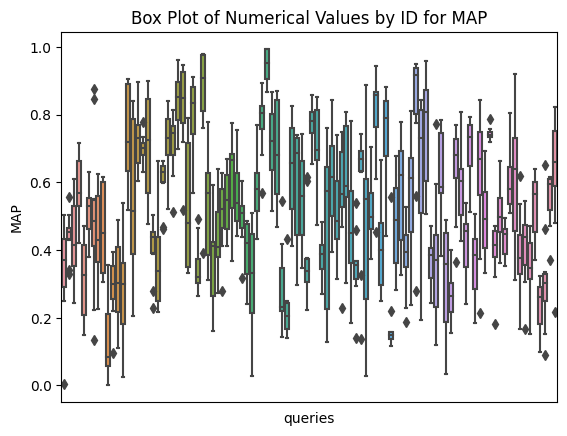

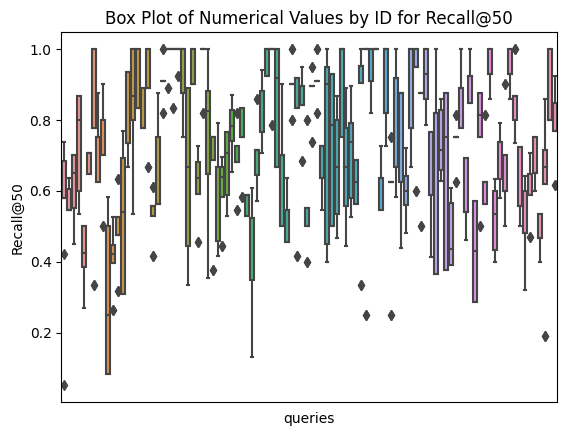

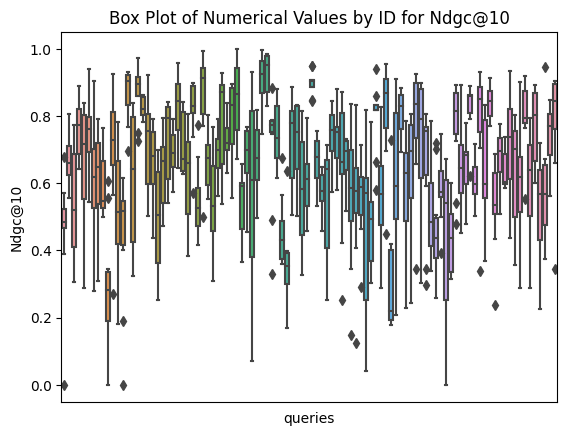

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

analysis_folder = "/home/ubuntu/task-search-quality/measurements/diy/analysis"

for result in results["DIY"]:
    
    df = results["DIY"][result]
    index = df.groupby(by=["query_id"])["metric_val"].transform(max) == df['metric_val']

    metric_best = df[index].sort_values(["query_id"])
    metric_best.to_csv(os.path.join(analysis_folder, f"diy-{result}-best.csv"), index=False)

    model_names = df["model"].unique()
    queries_list = []
    for model_name in model_names:
        best_queries_for_map = metric_best[metric_best["model"] == model_name]
        for i, query in best_queries_for_map.iterrows():
            query_row = queries["DIY"][queries["DIY"]["id"] == query["query_id"]].iloc[0]
            queries_list.append([query["query_id"], query_row["raw query"], model_name])
        
    queries_list_pd = pd.DataFrame(queries_list)
    queries_list_pd.to_csv(os.path.join(analysis_folder, f"diy-{result}-best-elaboration.csv"), index=False)


    sns.boxplot(x=df["query_id"], y=df["metric_val"])
    plt.title(f"Box Plot of Numerical Values by ID for {result}")
    plt.ylabel(result)
    plt.xlabel("queries")
    plt.xticks([])
    plt.show()